# Parking Lot Occupancy Detection Notebook

This notebook demonstrates the process of building, training, and evaluating a deep learning model for parking lot occupancy detection with the best parameters were found during development(`machine_learning.ipynb`). The model is trained using a dataset of images categorized as "Empty" or "Not Empty" and leverages the MobileNetV2 architecture for efficient feature extraction.

The trained model is saved in the folder `../model`, making it accessible for real-life scenarios. This allows the model to be deployed in applications such as real-time parking lot monitoring systems, where it can predict the occupancy status of parking spaces based on input images. Additionally, the saved model can be loaded and fine-tuned for further improvements or adaptations to new datasets.

In [1]:
# Standard libraries
import os
import random
import math
import hashlib
import json

# Image processing and manipulation
from PIL import Image, ImageStat
import matplotlib.pyplot as plt
import numpy as np

# Data manipulation and machine learning
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from scipy.ndimage import median_filter
import cv2
from sklearn.model_selection import KFold

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Machine learning evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc

# Visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as font_manager
from scipy.ndimage import median_filter

In [2]:
# Project path
project_path = '/content/drive/MyDrive/parkinglot_project'

In [3]:
# Dataset paths in google drive
dataset_path = os.path.join(project_path, 'dataset/clf-data')
empty_path = os.path.join(dataset_path, 'empty')
not_empty_path = os.path.join(dataset_path, 'not_empty')

# Models directory
MODELS_DIRECTORY = os.path.join(project_path, 'saved_models')

# Create the directory if it doesn't exist
if not os.path.exists(MODELS_DIRECTORY):
    os.makedirs(MODELS_DIRECTORY)

In [4]:
# ==============================
# Directory Setup
# ==============================

# Define the directory name for saving images
OUTPUT_DIR = os.path.join(project_path, 'images')

# Check if the directory exists, if not, create it
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# ==============================
# Plot Styling & Customization
# ==============================

# Set a Minimalist Style
sns.set_style("whitegrid")

# Customize Matplotlib settings for a modern look
mpl.rcParams.update({
    'axes.edgecolor': 'grey',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
    'text.color': 'black'
})

# ==============================
# Font Configuration
# ==============================

# Path to the custom font file
FONT_PATH = os.path.join(project_path, 'fonts/Montserrat-Regular.ttf')

# Add the font to matplotlib's font manager
font_manager.fontManager.addfont(FONT_PATH)

# Set the font family to Montserrat
plt.rcParams['font.family'] = 'Montserrat'

In [ ]:
# --- Load and Preprocess Data ---

def load_image():
    '''Load images from the dataset directory.

    Parameters:
        None

    Returns:
        - train_dataset: tf.data.Dataset object for training data
        - val_dataset: tf.data.Dataset object for validation data
        - test_dataset: tf.data.Dataset object for testing data
        - class_names: List of class names in the dataset
    '''
    # Load full dataset and resize
    full_dataset = tf.keras.utils.image_dataset_from_directory(
        DATASET_PATH,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='int',
        shuffle=True,
        seed=42
    )

    class_names = full_dataset.class_names
    print("Class names:", class_names)

    for images, labels in full_dataset.take(1):
        print("Image shape:", images[0].shape)
        print("Image dtype:", images[0].dtype)
        print("Pixel min/max:", tf.reduce_min(images[0]).numpy(), tf.reduce_max(images[0]).numpy())

    # Get total batches
    total_batches = tf.data.experimental.cardinality(full_dataset).numpy()
    print ('Total batches:',total_batches )

    # Split dataset into training, validation, and testing datasets
    test_batches = math.floor(TEST_SIZE * total_batches)
    val_batches = math.floor(VAL_SIZE * total_batches)

    print (f"Test batches: {test_batches} of {BATCH_SIZE} images per batch, for a total of {test_batches*BATCH_SIZE} images")
    print (f"Val batches: {val_batches} of {BATCH_SIZE} images per batch, for a total of {val_batches*BATCH_SIZE} images")
    print (f"Train batches: {total_batches - test_batches - val_batches} of {BATCH_SIZE} images per batch, for a total of {(total_batches - test_batches - val_batches)*BATCH_SIZE} images")

    assert test_batches + val_batches <= total_batches, \
        "Sum of test and validation batches exceeds total number of batches"

    # Split the dataset
    test_dataset = full_dataset.take(test_batches)
    val_dataset = full_dataset.skip(test_batches).take(val_batches)
    train_dataset = full_dataset.skip(test_batches + val_batches)

    # Prefetch and cache data for better pipeline performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE).cache()
    val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE).cache()
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE).cache()

    return train_dataset, val_dataset, test_dataset, class_names

In [ ]:
# --- Build the Model using MobileNetV2 ---

def build_and_compile_model_mobilenetv2(include_top = False, freeze = False, learning_rate = 0.0001, dropout = 0.3):
    '''Build, pre-process and compile a MobileNetV2 model.
    
    Parameters:
        - include_top (bool): Whether to include the top layer of the model.
        - freeze (bool): Whether to freeze the base model layers.
        - learning_rate (float): Learning rate for the optimizer.
        - dropout (float): Dropout rate for the model.

    Returns:
        - model (tf.keras.Model): Compiled MobileNetV2 model.
    ''' 

    # Input layer
    inputs = tf.keras.Input(shape=IMAGE_SHAPE)

    # Preprocessing inside the model
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)

    # Base model
    base_model = MobileNetV2(input_shape=IMAGE_SHAPE, include_top=include_top, weights='imagenet')
    base_model.trainable = freeze  # Freeze the base model
    x = base_model(x, training=False)

    # Custom Layers
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # use softmax and Dense(2) for >2 classes

    # Build full model
    model = tf.keras.Model(inputs, outputs)

    # --- Compile ---
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# --- Train ---

def train_model(class_names, model, train_dataset, val_dataset):
    '''Compile a basemodel MobileNetV2 model.

    Parameters:
        - base_model (tf.keras.Model): Pre-trained MobileNetV2 model.
        - freeze (bool): Whether to freeze the base model layers.
        - learning_rate (float): Learning rate for the optimizer.

    Returns:
        - model (tf.keras.Model): Compiled MobileNetV2 model.
    '''
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
    checkpoint = ModelCheckpoint(os.path.join(MODELS_DIRECTORY, f'best_model_{WORD}.keras'), monitor='val_loss', save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        callbacks=[lr_scheduler, checkpoint, early_stopping]
    )

    # Save model
    model.save(os.path.join(MODELS_DIRECTORY, f'final_model_{WORD}.keras'))

    # Save training history
    with open(os.path.join(MODELS_DIRECTORY, f'training_history_base_model_{WORD}.json'), 'w') as file: # open creates a file
        json.dump(history.history, file) # dump saves it as a json file

    # Saves classes name
    with open(os.path.join(MODELS_DIRECTORY, f'class_names_{WORD}.json'), 'w') as f:
        json.dump(class_names, f)

    return model, history

In [ ]:
# --- Evaluate training ---

def evaluate_training(model, history, train_dataset, val_dataset):
    '''Evaluate the model using the training and validation datasets.

    Parameters:
        - model (tf.keras.Model): Trained model.
        - history (tf.keras.callbacks.History): Training history.
        - train_dataset (tf.data.Dataset): Training dataset.
        - val_dataset (tf.data.Dataset): Validation dataset.

    Returns:
        - None
    '''	
    
    loss, acc = model.evaluate(val_dataset)
    print(f"Validation Accuracy: {acc:.2f}")

    print(f"{'*'*150}")

    # Extract accuracy and loss values from history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot Accuracy
    axes[0].plot(train_accuracy, label='Train Accuracy')
    axes[0].plot(val_accuracy, label='Validation Accuracy')
    axes[0].set_title('Accuracy per Epoch')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(which='both', linestyle='--', alpha=0.5)

    # Plot Loss
    axes[1].plot(train_loss, label='Train Loss')
    axes[1].plot(val_loss, label='Validation Loss')
    axes[1].set_title('Loss per Epoch')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(which='both', linestyle='--', alpha=0.5)

    plt.suptitle('Training History', fontsize=16)

    # Save the figure
    plt.savefig(os.path.join(OUTPUT_DIR, f"training_history_model_{WORD}.png"),
                    bbox_inches='tight',
                    facecolor='none',
                    transparent=True)

    plt.tight_layout()
    plt.show()

In [ ]:
# --- Evaluate in test dataset ---

def evaluate_test_dataset(model, test_dataset):
    '''Evaluate the model using the test dataset.

    Parameters:
        - model (tf.keras.Model): Trained model.
        - test_dataset (tf.data.Dataset): Test dataset.

    Returns:
        - None
    '''
    
    loss, acc = model.evaluate(test_dataset)
    print(f"Test Accuracy: {acc:.2f}")

    print(f"{'*'*15}")

    predictions = []
    true_labels = []
    pred_probabilities = []

    # Iterate over the test dataset and collect predictions and true labels
    for images, labels in test_dataset:
        preds = model.predict(images)
        pred_probabilities.extend(preds)
        preds = (preds >= 0.5).astype(int)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    # --- Confusion Matrix ---
    conf_matrix = confusion_matrix(true_labels, predictions)

    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Empty', 'Not Empty'], yticklabels=['Empty', 'Not Empty'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    # Save the figure
    plt.savefig(os.path.join(OUTPUT_DIR, f"confusion_matrix_{WORD}.png"),
                    bbox_inches='tight',
                    facecolor='none',
                    transparent=True)
    plt.show()

    # Confusion matrix as a JSON file
    with open(os.path.join(MODELS_DIRECTORY, f'confusion_matrix_{WORD}.json'), 'w') as f:
        json.dump(conf_matrix.tolist(), f)

    # Classification report
    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=['Empty', 'Not Empty']))

    # --- ROC Curve and AUC ---
    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(true_labels, np.array(pred_probabilities).flatten())
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Random classifier line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(which='both', linestyle='--', alpha=0.5)

    plt.savefig(os.path.join(OUTPUT_DIR, f"roc_curve_{WORD}.png"),
                bbox_inches='tight',
                facecolor='none',
                transparent=True)
    plt.show()

    # Optionally, save the ROC curve data
    with open(os.path.join(MODELS_DIRECTORY, f'roc_curve_{WORD}.json'), 'w') as f:
        roc_data = {
            'fpr': fpr.tolist(),
            'tpr': tpr.tolist(),
            'roc_auc': roc_auc
        }
        json.dump(roc_data, f)


In [ ]:
def plot_data_with_predictions(model, test_dataset, class_names):
    '''Visualize predictions on test data.

    Parameters:
        - model (tf.keras.Model): Trained model.
        - test_dataset (tf.data.Dataset): Test dataset.
        - class_names (list): List of class names.

    Returns:
        - None
    '''

    # Get a batch of test data
    image_batch, label_batch = test_dataset.as_numpy_iterator().next()
    image_batch = image_batch.astype('float32')

    # Generate predictions
    predictions = model.predict_on_batch(image_batch).flatten()
    predictions = tf.where(predictions < 0.5, 0, 1).numpy()

    # Visualize predictions
    plt.figure(figsize=(17, 17))
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        image = image_batch[i]

        image = np.array(image)
        image_to_show = image.astype(np.uint8)

        plt.imshow(image_to_show)
        #plt.imshow(image_batch[i])
        true_label = label_batch[i]
        pred_label = predictions[i]
        title = f"True: {class_names[true_label].replace('_',' ').title()}\nPred: {class_names[pred_label].replace('_',' ').title()}"
        color = 'green' if true_label == pred_label else 'red'
        plt.title(title, color=color, fontsize=10)
        plt.axis("off")
    plt.suptitle("Predictions on Test Data", fontsize=16, fontweight='bold', )
    plt.subplots_adjust(top=0.76)
    plt.savefig(os.path.join(OUTPUT_DIR, f"predictions_on_test_data_{WORD}.png"),
                    bbox_inches='tight',
                    facecolor='none',
                    transparent=True)
    plt.tight_layout()

    plt.show()

In [ ]:
# Function to scan the training data and plot misclassified images
def plot_misclassified_images(model, test_dataset, class_names):
    '''Visualize misclassified images.

    Parameters:
        - model (tf.keras.Model): Trained model.
        - test_dataset (tf.data.Dataset): Test dataset.
        - class_names (list): List of class names.

    Returns:
        - None
    '''
    
    misclassified_images = []
    true_labels = []
    pred_labels = []

    # Iterate over the dataset
    for image_batch, label_batch in test_dataset:
        # Generate predictions
        predictions = model.predict_on_batch(image_batch).flatten()
        predictions = tf.where(predictions < 0.5, 0, 1).numpy()

        # Identify misclassified images
        for i in range(len(label_batch)):
            if predictions[i] != label_batch[i]:
                misclassified_images.append(image_batch[i].numpy())
                true_labels.append(label_batch[i])
                pred_labels.append(predictions[i])

    # Plot the misclassified images
    plt.figure(figsize=(15, 15))
    for i in range(min(16, len(misclassified_images))):  # Limit to 16 images for display
        ax = plt.subplot(4, 4, i + 1)

        image = misclassified_images[i]

        image = np.array(image)
        image_to_show = image.astype(np.uint8)

        plt.imshow(image_to_show)
        #plt.imshow(misclassified_images[i].astype('float32'))
        true_label = true_labels[i]
        pred_label = pred_labels[i]
        title = f"True: {class_names[true_label].replace('_',' ').title()}\nPred: {class_names[pred_label].replace('_',' ').title()}"
        color = 'green' if true_label == pred_label else 'red'
        plt.title(title, color=color, fontsize=10)
        plt.axis("off")

    plt.suptitle("Misclassified Images", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    # Save the figure
    plt.savefig(os.path.join(OUTPUT_DIR, f"misclassified_images_{WORD}.png"),
                    bbox_inches='tight',
                    facecolor='none',
                    transparent=True)
    plt.show()

In [11]:
# --- Step 1: Set Parameters ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
DATASET_PATH = dataset_path

VAL_SIZE = 0.15
TEST_SIZE = 0.20

IMAGE_SHAPE = (224, 224, 3)

WORD = 'best_model'

In [12]:
train_dataset, val_dataset, test_dataset, class_names = load_image()

Found 6090 files belonging to 2 classes.
Class names: ['empty', 'not_empty']
Image shape: (224, 224, 3)
Image dtype: <dtype: 'float32'>
Pixel min/max: 4.927328 219.40182
Total batches: 191
Test batches: 38 of 32 images per batch, for a total of 1216 images
Val batches: 28 of 32 images per batch, for a total of 896 images
Train batches: 125 of 32 images per batch, for a total of 4000 images


Image shape: (224, 224, 3)
Image dtype: float32
Pixel min/max: 0.5650074 225.78468


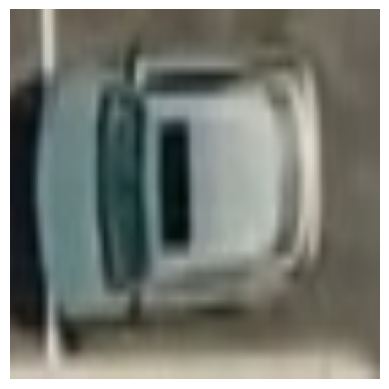

In [13]:
# Cheking that the images are resize and rescale
for images, labels in test_dataset.take(1):
    image = np.array(images[0])

    print("Image shape:", image.shape)
    print("Image dtype:", image.dtype)
    print("Pixel min/max:", tf.reduce_min(image).numpy(), tf.reduce_max(image).numpy())

    # Convert label to class name
    label_index = labels[0].numpy()
    class_name = class_names[label_index]

    # Plot the first image
    #image_to_show = tf.cast(image, tf.float32)
    image_to_show = image.astype(np.uint8)
    #plt.imshow(image_to_show.numpy())
    plt.imshow(image_to_show)
    #plt.title(f"Label: {class_name.replace('_',' ').title()}")
    plt.axis('off')
    plt.show()
    break

In [14]:
model = build_and_compile_model_mobilenetv2(learning_rate = 0.0001)
model, history = train_model(class_names, model, train_dataset, val_dataset)

Epoch 1/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 134ms/step - accuracy: 0.5096 - loss: 0.9199 - val_accuracy: 0.9051 - val_loss: 0.4118 - learning_rate: 1.0000e-04
Epoch 2/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8388 - loss: 0.4067 - val_accuracy: 0.9542 - val_loss: 0.2321 - learning_rate: 1.0000e-04
Epoch 3/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9380 - loss: 0.2431 - val_accuracy: 0.9732 - val_loss: 0.1617 - learning_rate: 1.0000e-04
Epoch 4/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9624 - loss: 0.1659 - val_accuracy: 0.9777 - val_loss: 0.1258 - learning_rate: 1.0000e-04
Epoch 5/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9702 - loss: 0.1340 - val_accuracy: 0.9810 - val_loss: 0.1028 - learning_rate: 1.0000e-04
Epoch 6/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9806 - loss: 0.1060 - val_accuracy: 0.9821 - val_loss: 0.0870 - learning_rate: 1.0000e-04
Epoch 7/15
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - a

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9947 - loss: 0.0319
Validation Accuracy: 0.99
******************************************************************************************************************************************************


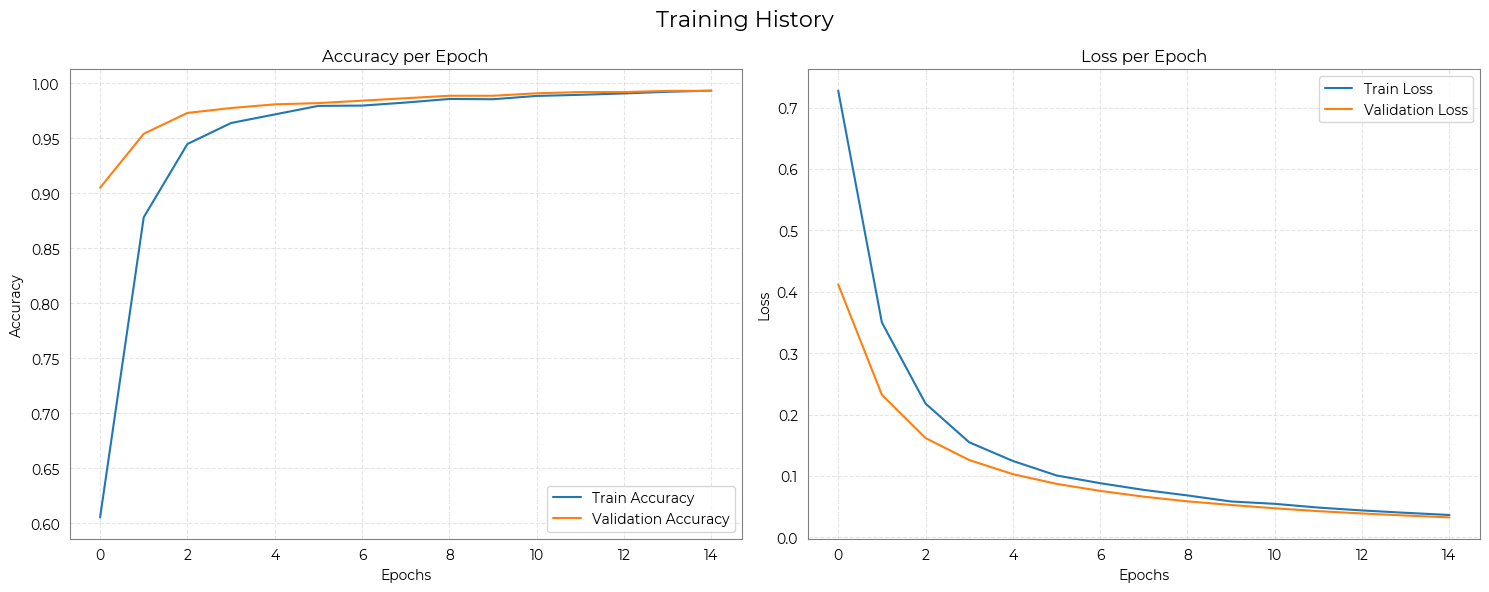

In [15]:
evaluate_training(model, history, train_dataset, val_dataset)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9956 - loss: 0.0332
Test Accuracy: 1.00
***************
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━

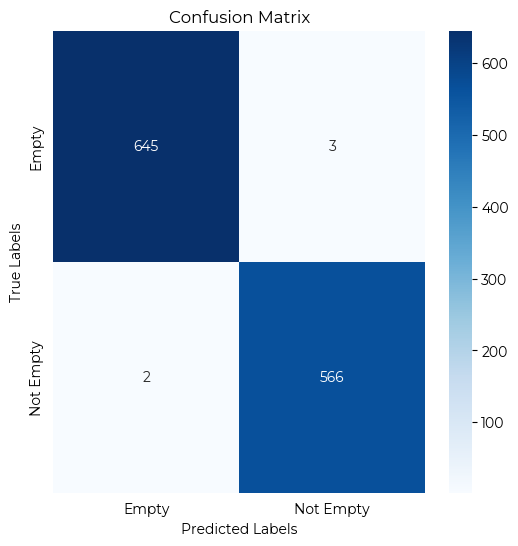

Classification Report:
              precision    recall  f1-score   support

       Empty       1.00      1.00      1.00       648
   Not Empty       0.99      1.00      1.00       568

    accuracy                           1.00      1216
   macro avg       1.00      1.00      1.00      1216
weighted avg       1.00      1.00      1.00      1216



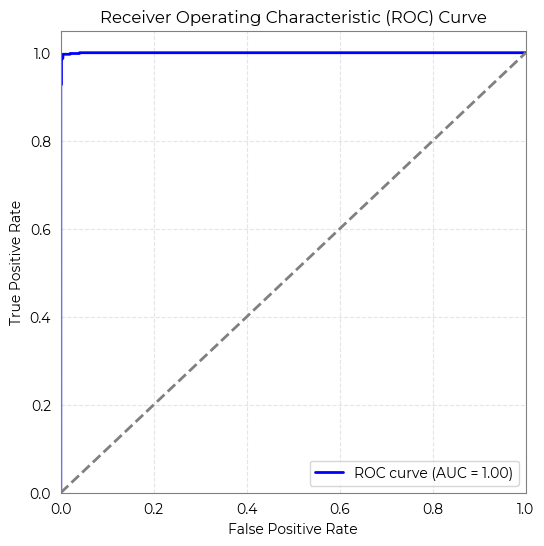

In [16]:
evaluate_test_dataset(model, test_dataset)

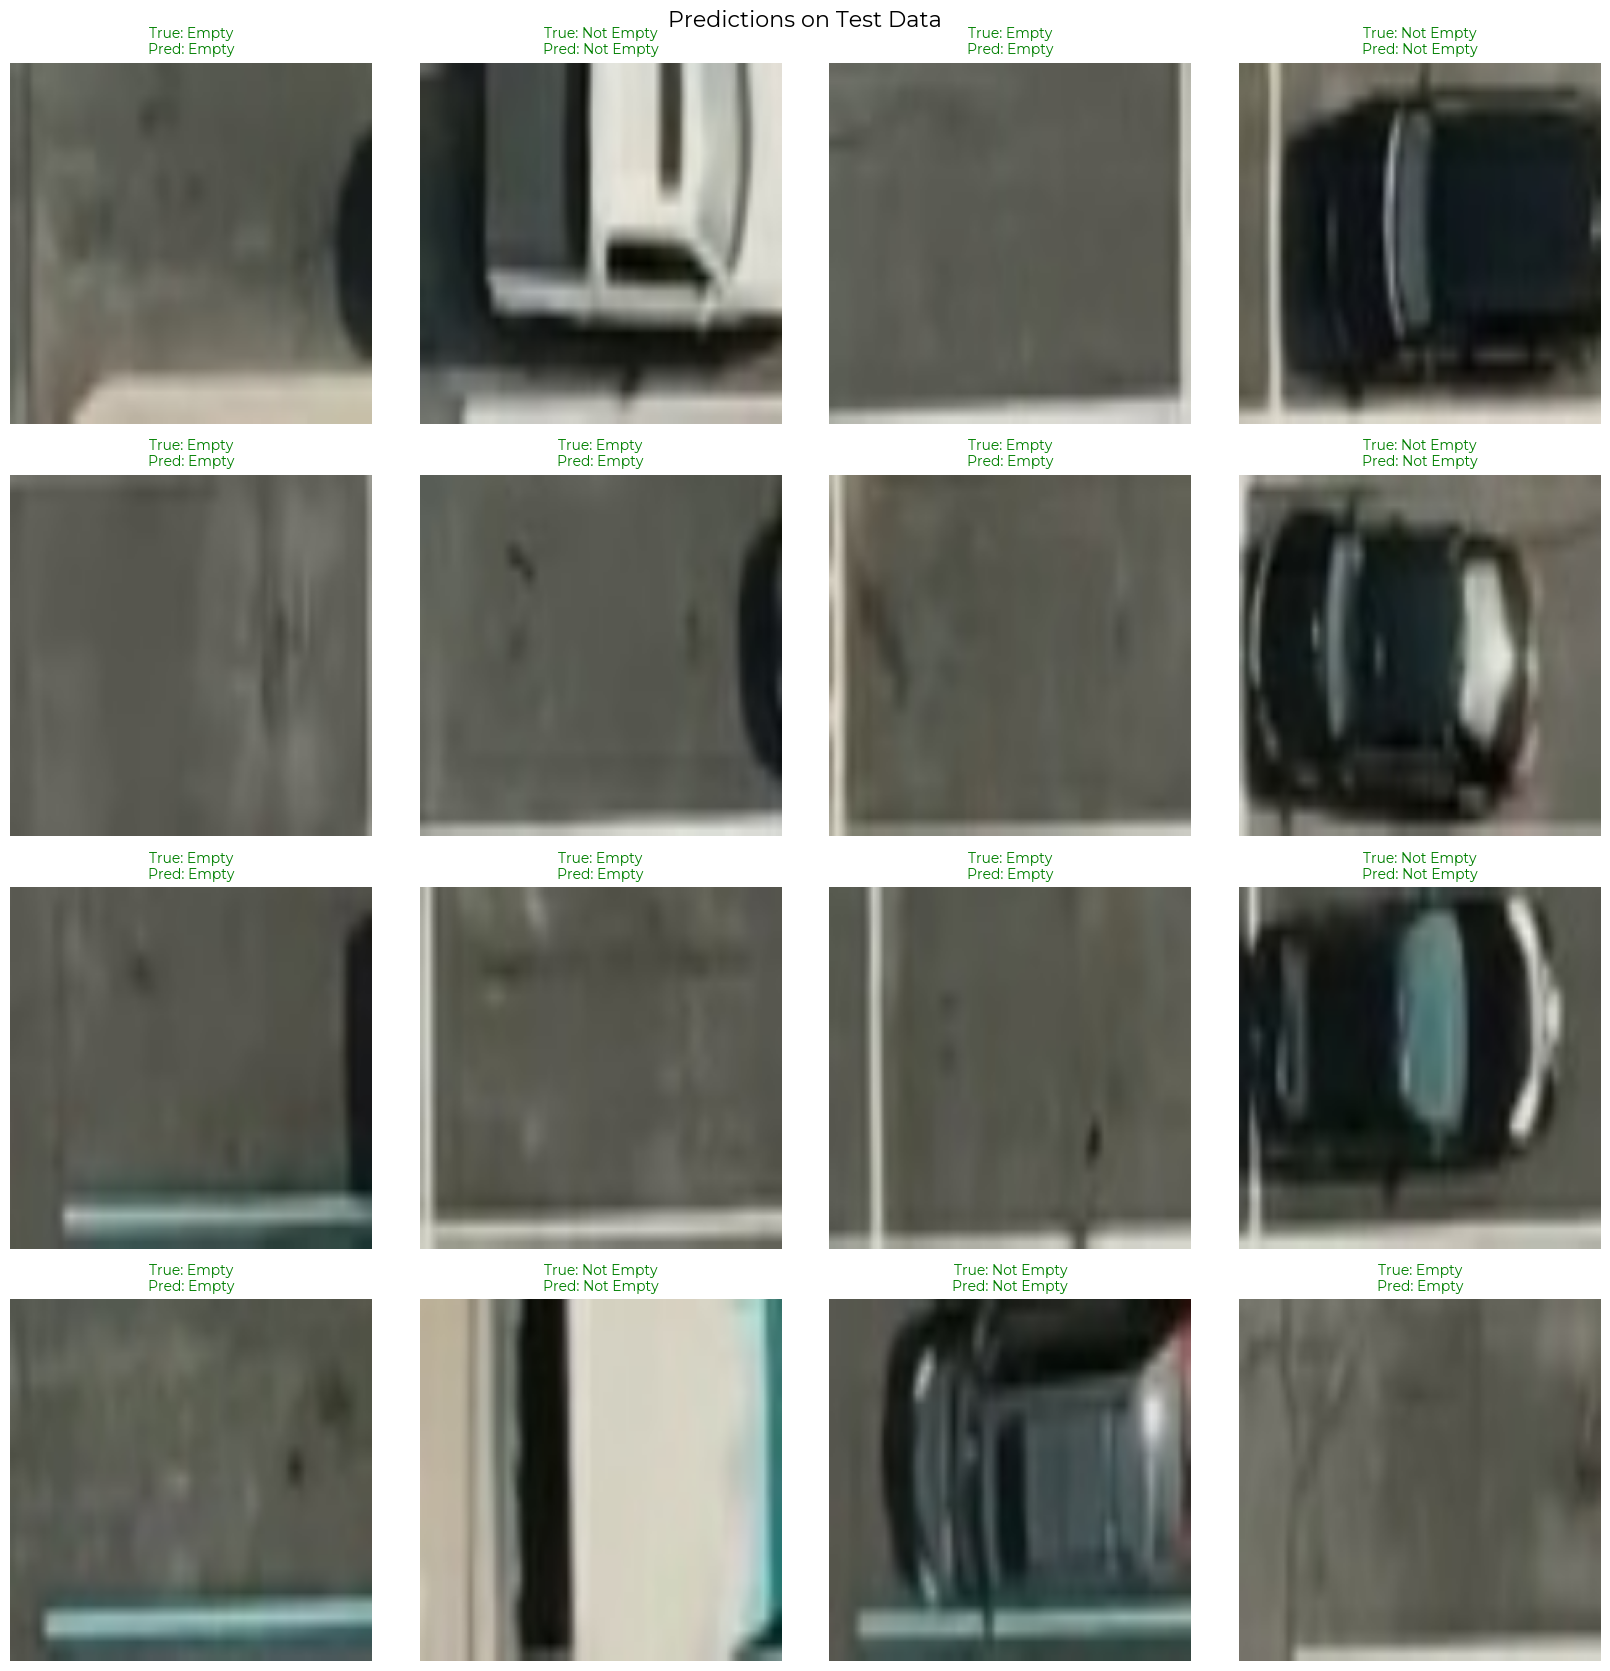

In [17]:
plot_data_with_predictions(model, test_dataset, class_names)

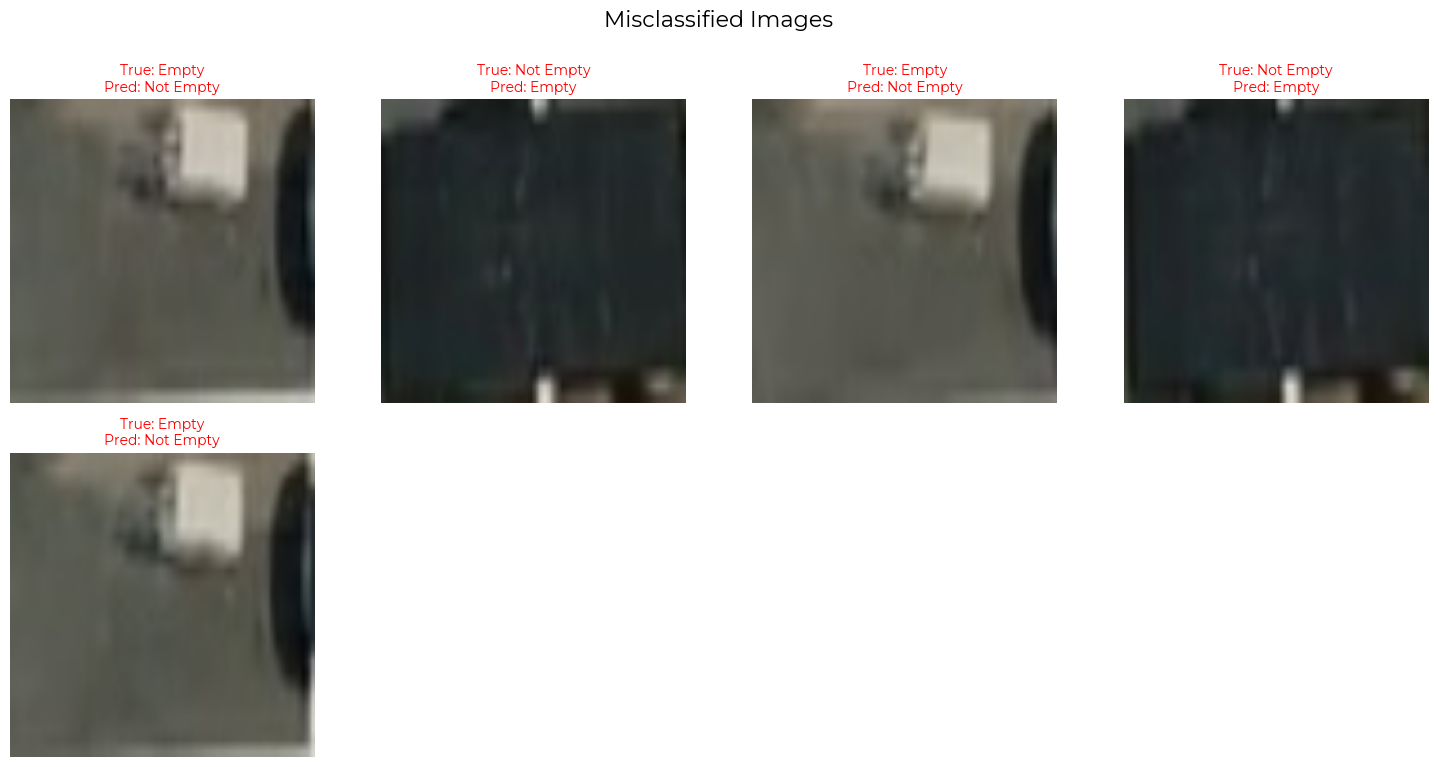

In [20]:
# Call the function to plot misclassified images
plot_misclassified_images(model, test_dataset, class_names)